In [100]:
import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [102]:
import os
from PIL import Image
import numpy as np

categories = os.listdir('./data/train')

names_to_labels = dict()

training_images = []
training_labels = []

for i in range(len(categories)):
    names_to_labels[categories[i]] = i

for c in categories:
    files = os.listdir('./data/train/' + c)
    for f in files:
        image = Image.open('./data/train/' + c + '/' + f)
        image = image.resize((32,32))
        image = np.array(image) 

        training_images.append(transform(image))
        training_labels.append(names_to_labels[c])


In [103]:
categories = os.listdir('./data/test')

names_to_labels = dict()

test_images = []
test_labels = []

for i in range(len(categories)):
    names_to_labels[categories[i]] = i

for c in categories:
    files = os.listdir('./data/test/' + c)
    for f in files:
        image = Image.open('./data/test/' + c + '/' + f)
        image = image.resize((32,32))
        image = np.array(image) 

        test_images.append(transform(image))
        test_labels.append(names_to_labels[c])

test_images = torch.stack(test_images)
test_labels = torch.tensor(test_labels)


In [106]:
print(len(training_images))
print(len(training_labels))


12594
12594


In [108]:
training_images = torch.stack(training_images)

In [110]:
training_labels = torch.tensor(training_labels)

In [112]:
test_images.shape

torch.Size([500, 3, 32, 32])

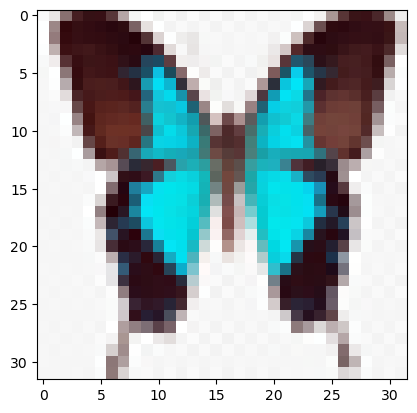

In [114]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(training_images[12000])


In [116]:
from torch import nn, optim
from torch.functional import F

# Define the CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(categories))  # Adjust the output size based on the number of categories

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model  
net = Net()


In [118]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [161]:
# Training loop
num_ex = 250
batch_size = 160

for ex in range(num_ex):
    running_loss = 0.0
    for i in range(0, len(training_images), batch_size):
        # Get the inputs
        inputs = training_images[i:i+batch_size]
        labels = training_labels[i:i+batch_size]
        
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = net(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        running_loss += loss.item()
        if (i // batch_size) % 10 == 0:  # Print every 10 batches
            print(f"ex [{ex+1}/{num_ex}], Step [{i+1}/{len(training_images)}], Loss: {running_loss/10:.4f}")
            running_loss = 0.0

print('Finished Training')

ex [1/250], Step [1/12594], Loss: 0.0001
ex [1/250], Step [1601/12594], Loss: 0.0007
ex [1/250], Step [3201/12594], Loss: 0.0007
ex [1/250], Step [4801/12594], Loss: 0.0014
ex [1/250], Step [6401/12594], Loss: 0.0007
ex [1/250], Step [8001/12594], Loss: 0.0006
ex [1/250], Step [9601/12594], Loss: 0.0006
ex [1/250], Step [11201/12594], Loss: 0.0008
ex [2/250], Step [1/12594], Loss: 0.0001
ex [2/250], Step [1601/12594], Loss: 0.0007
ex [2/250], Step [3201/12594], Loss: 0.0007
ex [2/250], Step [4801/12594], Loss: 0.0014
ex [2/250], Step [6401/12594], Loss: 0.0007
ex [2/250], Step [8001/12594], Loss: 0.0006
ex [2/250], Step [9601/12594], Loss: 0.0006
ex [2/250], Step [11201/12594], Loss: 0.0008
ex [3/250], Step [1/12594], Loss: 0.0001
ex [3/250], Step [1601/12594], Loss: 0.0007
ex [3/250], Step [3201/12594], Loss: 0.0007
ex [3/250], Step [4801/12594], Loss: 0.0014
ex [3/250], Step [6401/12594], Loss: 0.0007
ex [3/250], Step [8001/12594], Loss: 0.0006
ex [3/250], Step [9601/12594], Loss: 0.

In [162]:
# Save the trained model
torch.save(net.state_dict(), 'butterfly_cnn_82024_1.pth')

# Testing (on the same dataset for simplicity)
correct = 0
total = 0
with torch.no_grad():
    for i in range(len(training_images)):
        outputs = net(training_images[i].unsqueeze(0))
        _, predicted = torch.max(outputs.data, 1)
        total += 1
        correct += (predicted == training_labels[i]).sum().item()

print(f'Accuracy of the network on the training images: {100 * correct / total:.2f}%')


Accuracy of the network on the training images: 100.00%


In [163]:
# Save the trained model
torch.save(net.state_dict(), 'butterfly_cnn.pth')

# Testing (on the same dataset for simplicity)
correct = 0
total = 0
with torch.no_grad():
    for i in range(len(test_images)):
        outputs = net(test_images[i].unsqueeze(0))
        _, predicted = torch.max(outputs.data, 1)
        total += 1
        correct += (predicted == test_labels[i]).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total:.2f}%')


Accuracy of the network on the test images: 54.80%


In [ ]:
!pip install torch


In [ ]:
!pip install torchvision


In [ ]:
pip install torch torchvision pillow